Notebook de l'expérience
-----

### Librairies utilisées

In [1]:
import pandas as pd
import numpy as np
import gc

from pandas_profiling import ProfileReport

from transparentai.datasets import variable

In [2]:
gc.collect()

0

### Chargement des données

In [3]:
data = pd.read_csv('data/application_train.csv', sep=',')

### Analyse rapide du jeu de données

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [5]:
data.shape

(307511, 122)

In [6]:
data.sample(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
301627,449435,0,Cash loans,F,N,Y,0,67500.0,187704.0,6871.5,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,1.0
165960,292396,0,Cash loans,F,N,Y,2,67500.0,76410.0,8154.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
223607,358995,0,Cash loans,M,N,N,0,270000.0,2517300.0,69354.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


### Pandas profiling

In [8]:
profile = ProfileReport(data, title="Credit Home Default application train", minimal=True)

In [8]:
profile.to_file("analyse_donnees_credit_home_application.html")

In [6]:
gc.collect()

3518

Pour plus de détail aller sur le rapport de [Pandas profiling](analyse_donnees_credit_home_application.html)

### Analyse des données

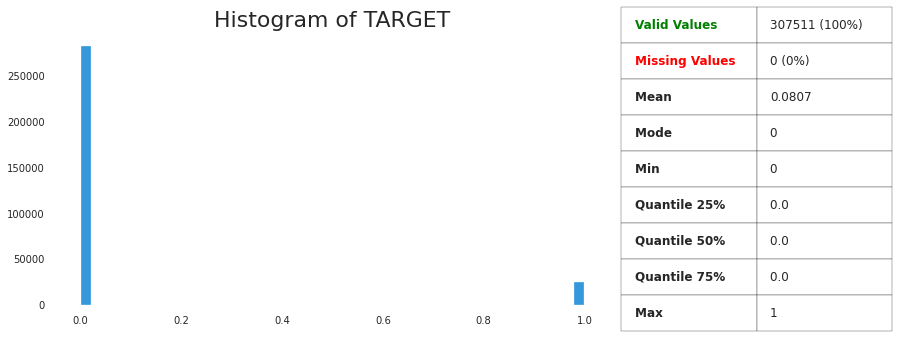

In [7]:
variable.plot_variable(data['TARGET'])

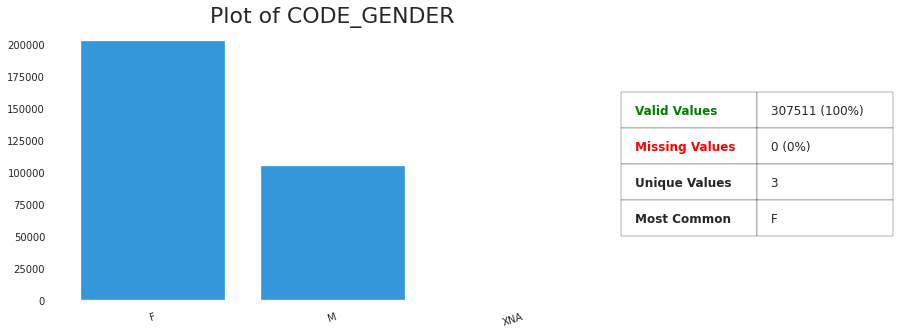

In [8]:
variable.plot_variable(data['CODE_GENDER'])

Afin de rendre l'expérience plus juste nous allons supprimer les valeurs `XNA` du jeu de données

In [9]:
data = data[data['CODE_GENDER'] != 'XNA']

Nous supprimons la colonnes `SK_ID_CURR` qui correspond à l'id des applications

In [10]:
data = data.drop(columns='SK_ID_CURR')

#### Valeurs manquantes

In [15]:
def get_missing_val(df):
    df = df.copy()
    na_df = (df.isna().sum() / len(df)) * 100
    na_df = na_df[na_df > 0]
    na_df = na_df.sort_values(ascending=False)
    
    return na_df

na_df = get_missing_val(data)

In [12]:
na_df

COMMONAREA_MEDI             69.872231
COMMONAREA_AVG              69.872231
COMMONAREA_MODE             69.872231
NONLIVINGAPARTMENTS_AVG     69.433216
NONLIVINGAPARTMENTS_MODE    69.433216
                              ...    
EXT_SOURCE_2                 0.214629
AMT_GOODS_PRICE              0.090404
AMT_ANNUITY                  0.003902
CNT_FAM_MEMBERS              0.000650
DAYS_LAST_PHONE_CHANGE       0.000325
Length: 67, dtype: float64

In [13]:
def handle_missing_values(df):
    df = df.copy()
    
    num_vars = df.select_dtypes('number').columns
    oth_vars = [c for c in df.columns if c not in num_vars]
    
    df.loc[:,num_vars] = df[num_vars].fillna(df[num_vars].median())
    
    for var in oth_vars:
        df.loc[:,var] = df[var].fillna(df[var].value_counts().index[0])
        
    return df    

In [14]:
data = handle_missing_values(data)

In [16]:
na_df = get_missing_val(data)

In [17]:
na_df

Series([], dtype: float64)

In [19]:
gc.collect()

13634

### Analyse des variables catégoriques

In [18]:
categorical_variables = data.select_dtypes('object').columns

In [20]:
cnt_distinct_cat_var = data[categorical_variables].nunique()
cnt_distinct_cat_var

NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Nous supprimons les deux colonnes ci-dessous car elles ont trop de variables et nous allons réaliser une transformation de One hot encoding.

In [21]:
cols_to_drop = ['OCCUPATION_TYPE','ORGANIZATION_TYPE']

In [22]:
data = data.drop(columns=cols_to_drop)

Regardons les variables avec seulement deux valeurs distinctes

In [23]:
data[cnt_distinct_cat_var[cnt_distinct_cat_var == 2].index].apply(lambda x: x.unique())

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,EMERGENCYSTATE_MODE
0,Cash loans,M,N,Y,No
1,Revolving loans,F,Y,N,Yes


Nous convertissons ces variables en binaire (0 ou 1)

In [24]:
data['NAME_CONTRACT_TYPE'] = data['NAME_CONTRACT_TYPE'].replace({'Cash loans':0,'Revolving loans':1})
data['CODE_GENDER'] = data['CODE_GENDER'].replace({'F':0,'M':1})
data['FLAG_OWN_CAR'] = data['FLAG_OWN_CAR'].replace({'Y':0,'N':1})
data['FLAG_OWN_REALTY'] = data['FLAG_OWN_REALTY'].replace({'Y':0,'N':1})
data['EMERGENCYSTATE_MODE'] = data['EMERGENCYSTATE_MODE'].replace({'No':0,'Yes':1})

In [25]:
data[cnt_distinct_cat_var[cnt_distinct_cat_var == 2].index].apply(lambda x: x.unique())

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,EMERGENCYSTATE_MODE
0,0,1,1,0,0
1,1,0,0,1,1


Encodage des variables qualitatives en one hot encoding, exemple de one hot encoding :

![](https://img.over-blog-kiwi.com/2/10/64/42/20190302/ob_5e7622_mtimfxh.png)

In [26]:
categorical_variables = data.select_dtypes('object').columns

In [27]:
def one_hot_encoding(df, col):
    one_hot = pd.get_dummies(df[col], prefix=col)
    df[one_hot.columns] = one_hot
        
    df = df.drop(columns=col)
    
    return df

In [28]:
data_encoded = data.copy()

In [30]:
for var in categorical_variables:
    data_encoded = one_hot_encoding(data_encoded, var)

In [31]:
data_encoded

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden
0,1,0,1,1,0,0,202500.0,406597.5,24700.5,351000.0,...,1,0,0,0,0,0,0,0,1,0
1,0,0,0,1,1,0,270000.0,1293502.5,35698.5,1129500.0,...,1,0,0,1,0,0,0,0,0,0
2,0,1,1,0,0,0,67500.0,135000.0,6750.0,135000.0,...,1,0,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,135000.0,312682.5,29686.5,297000.0,...,1,0,0,0,0,0,0,1,0,0
4,0,0,1,1,0,0,121500.0,513000.0,21865.5,513000.0,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,0,1,1,1,0,157500.0,254700.0,27558.0,225000.0,...,1,0,0,0,0,0,0,0,1,0
307507,0,0,0,1,0,0,72000.0,269550.0,12001.5,225000.0,...,1,0,0,0,0,0,0,0,1,0
307508,0,0,0,1,0,0,153000.0,677664.0,29979.0,585000.0,...,1,0,0,0,0,0,0,1,0,0
307509,1,0,0,1,0,0,171000.0,370107.0,20205.0,319500.0,...,1,0,0,0,0,0,0,0,1,0


In [35]:
data_encoded.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('uint8')], dtype=object)

Parfait, il ne nous reste que des variables numériques !

### Corrélation avec le genre

In [36]:
corr = variable.compute_correlation(data)

In [37]:
corr['CODE_GENDER'].sort_values().abs().sort_values(ascending=False)[:10]

CODE_GENDER                    1.000000
FLAG_OWN_CAR                   0.345848
FLAG_DOCUMENT_8                0.249800
EXT_SOURCE_1                   0.198069
FLAG_EMP_PHONE                 0.157245
DAYS_EMPLOYED                  0.156009
DAYS_BIRTH                     0.148067
REG_CITY_NOT_WORK_CITY         0.137577
LIVE_CITY_NOT_WORK_CITY        0.133271
LIVE_REGION_NOT_WORK_REGION    0.106078
Name: CODE_GENDER, dtype: float64

In [38]:
gc.collect()

40

Aucune variable ne sera donc à enlever excepté le `CODE_GENRE` pour la morale de Charline.

#### Séparation train et validation

In [42]:
from sklearn.model_selection import train_test_split

In [39]:
target = 'TARGET'
X, y = data_encoded.drop(columns=target), data_encoded[target]

# récupération des variables pour la morale de Charline
X_moral_c = X.drop(columns='CODE_GENDER')

In [57]:
X_train, X_test, y_train, y_test = train_test_split(
       X, y, test_size=0.2, random_state=42)

# récupération des variables pour la morale de Charline
X_train_moral_c = X_train.drop(columns='CODE_GENDER')
X_test_moral_c = X_test.drop(columns='CODE_GENDER')

In [58]:
X_train.shape, X_test.shape

((246005, 162), (61502, 162))

## Entraînement des modèles

In [47]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

In [48]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [75]:
rf = RandomForestClassifier(verbose=5, n_jobs=4)

rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               scoring = 'f1',
                               n_iter = 5, 
                               cv = 5, 
                               verbose=4, 
                               random_state=42, 
                               n_jobs = 4)

In [76]:
gc.collect()

40

In [ ]:
%%time
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


In [ ]:
clf = rf_random.best_estimator_
# clf = rf

In [ ]:
clf

### Performance

In [ ]:
from transparentai.models import classification

In [ ]:
y_pred = clf.predict_proba(X_test)

In [ ]:
classification.plot_performance(y_test, y_pred)